In [1]:
import numpy as np

import librosa
import librosa.display

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F
import torchaudio
from torchaudio.models import WaveRNN

from torchvision.utils import make_grid 
import matplotlib.pyplot as plt    
import os
import random
from tqdm import tqdm 

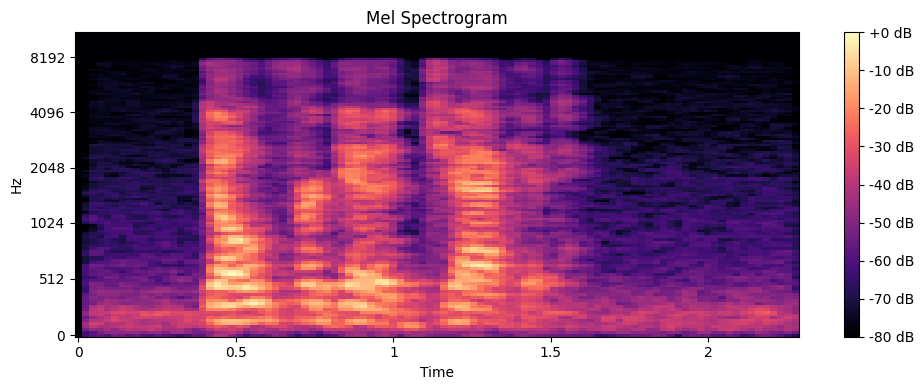

In [2]:
#Visualising the data

crema_d_spec_path = './AudioWAV/1001_DFA_ANG_XX.wav'
y, sr = librosa.load(crema_d_spec_path)

# Compute the spectrogram
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to decibel scale (log scale)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [3]:
waveform, sample_rate = torchaudio.load(crema_d_spec_path)
print(waveform.size(), sample_rate)

torch.Size([1, 36409]) 16000


In [13]:
#calculation
mw = 0
ms = 0
max_waveform_length = 80080
directory = './AudioWAV'
for filename in os.listdir(directory):
    if filename.endswith('.wav'):
        
        filepath = os.path.join(directory, filename)
        
        # Load audio waveform
        waveform, sr = torchaudio.load(filepath)

        waveform_length = waveform.size(1)
        if waveform_length < max_waveform_length:
            padding = torch.zeros(1, max_waveform_length - waveform_length)
            waveform = torch.cat([waveform, padding], dim=1)
        elif waveform_length > max_waveform_length:
            waveform = waveform[:, :max_waveform_length]
        
        # Compute spectrogram
        mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=80, n_fft=400, hop_length=162)
        spectrogram = mel_spec_transform(waveform)

        # Convert spectrogram to decibels
        amplitude_to_db_transform = torchaudio.transforms.AmplitudeToDB()
        spectrogram = amplitude_to_db_transform(spectrogram)

        mw = max(mw, waveform.size(1))
        ms = max(ms, spectrogram.size(2))

print(mw)
print(ms)


            
            

80080
495


In [14]:
def load_dataset(directory, max_waveform_length, max_spec_len):
    dataset = []
    emotion_to_number = {'NEU': 0, 'HAP': 1, 'SAD': 2, 'ANG': 3, 'DIS': 4, 'FEA': 5}
    max_len = 0
    
    # Iterate through files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            
            filepath = os.path.join(directory, filename)
            emotion = filename.split('_')[2]
            emotion_no = emotion_to_number[emotion]
            emotion_label = torch.zeros(6)
            emotion_label[emotion_no] = 1
            
            # Load audio waveform
            waveform, sr = torchaudio.load(filepath)
            
            waveform_length = waveform.size(1)
            if waveform_length < max_waveform_length:
                padding = torch.zeros(1, max_waveform_length - waveform_length)
                waveform = torch.cat([waveform, padding], dim=1)
            elif waveform_length > max_waveform_length:
                waveform = waveform[:, :max_waveform_length]
            
            # Compute spectrogram
            mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=80, n_fft=400, hop_length=162)
            spectrogram = mel_spec_transform(waveform)

            # Convert spectrogram to decibels
            amplitude_to_db_transform = torchaudio.transforms.AmplitudeToDB()
            spectrogram = amplitude_to_db_transform(spectrogram)
            
            # Pad or truncate spectrogram to max_spec_len
            spec_len = spectrogram.size(2)
            if spec_len < max_spec_len:
                padding = torch.zeros(1, 80, max_spec_len - spec_len)  # Add a new axis
                spectrogram = torch.cat([spectrogram, padding], dim=2)

            elif spec_len > max_spec_len:
                spectrogram = spectrogram[:, :, :max_spec_len]
            
            
            dataset.append((waveform, spectrogram, emotion_label))

    return dataset

def split_dataset(dataset, batch_size, train_ratio=0.8):

    # Split dataset into training and testing sets
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader objects for training and testing sets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataset, test_dataset, train_dataloader, test_dataloader

In [15]:
crema_d_path = './AudioWAV'
dataset = load_dataset(crema_d_path, 80514, 501)

In [16]:
train_dataset, test_dataset, train_dataloader, test_dataloader = split_dataset(dataset, 32)

In [17]:
print(len(dataset))
for batch_idx, (w, s, l) in enumerate(train_dataloader):
    print(w.size())
    print(s.size())
    print(l.size())
    break


7442
torch.Size([32, 1, 80514])
torch.Size([32, 1, 80, 501])
torch.Size([32, 6])


In [18]:
class RNN(nn.Module):
   def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN, self).__init__()
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
      self.fc = nn.Linear(hidden_size, num_classes)
   
   def forward(self, x):
      # Flatten the spectrogram data along the frequency_bins dimension
      x = x.view(x.size(0), -1, x.size(3))  # [batch_size, channels * frequency_bins, time_steps]
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
      c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
      out, _ = self.lstm(x, (h0, c0))  
      # Only take the output from the last time step
      out = self.fc(out[:, -1, :])  # [batch_size, num_classes]
      return out

In [19]:
#training step - 1 epoch
# specgram = specgram.view(specgram.size(0), specgram.size(1), -1)
def train_step(model, loss_function, optimizer, train_dataloader):

    losses = []
    for i, (_, specgram, label) in enumerate(tqdm(iter(train_dataloader))):
        
        optimizer.zero_grad()
        pred = model(specgram)
        loss = loss_function(pred, label) #err incompatible tensoor dimensions
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    return losses

In [24]:
def training(model, loss_function, optimizer, train_dataloader, n_epochs, update_interval):
    # model.train()
    losses = []

    for n in range(n_epochs):
        for i, (_, specgram, label) in enumerate(tqdm(iter(train_dataloader))):
            
            optimizer.zero_grad()
            pred = model(specgram)
            loss = loss_function(pred, label) #err incompatible tensoor dimensions
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            if i % update_interval == 0:
                losses.append(round(loss.item(), 2)) # This will append your losses for plotting -- please use "loss" as the name for your loss
        
    return model, losses

In [26]:
batch_size = 128
lr = 1e-4

input_size = 501  # input size after flattening the spectrogram
hidden_size = 20  # size of the hidden state
num_layers = 2  # number of LSTM layers
num_classes = 6  # number of output classes

train_dataset, test_dataset, train_dataloader, test_dataloader = split_dataset(dataset, batch_size)

# Initialize the LSTM model
model = RNN(input_size, hidden_size, num_layers, num_classes)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

l = train_step(model, loss_function, optimizer, train_dataloader)
print(l)

100%|██████████| 47/47 [00:01<00:00, 38.81it/s]

[1.8068386316299438, 1.7960911989212036, 1.7979720830917358, 1.7904715538024902, 1.799423336982727, 1.8030641078948975, 1.7902579307556152, 1.7971926927566528, 1.7936092615127563, 1.7958173751831055, 1.7988132238388062, 1.7827987670898438, 1.7815183401107788, 1.787192702293396, 1.7900629043579102, 1.7888298034667969, 1.775572419166565, 1.7944602966308594, 1.7860991954803467, 1.7773405313491821, 1.7864514589309692, 1.7937911748886108, 1.7898017168045044, 1.789515733718872, 1.7977986335754395, 1.8024024963378906, 1.7831690311431885, 1.798389196395874, 1.7819552421569824, 1.7858694791793823, 1.7950918674468994, 1.7916285991668701, 1.7871187925338745, 1.7898820638656616, 1.788887858390808, 1.778220772743225, 1.7871801853179932, 1.7901448011398315, 1.7962764501571655, 1.7977392673492432, 1.800845980644226, 1.7887425422668457, 1.7961621284484863, 1.7931119203567505, 1.7856545448303223, 1.7996735572814941, 1.786529302597046]


100%|██████████| 47/47 [00:01<00:00, 39.99it/s]


avg loss: 1.6473009684238678


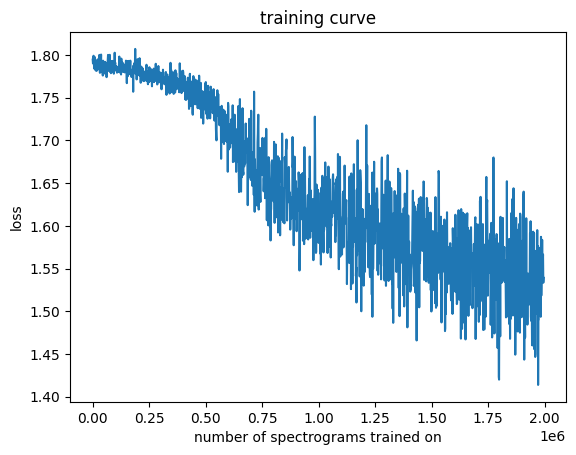

In [27]:

n_epochs = 30
update_interval = 10
trained_model, losses = training(model, loss_function, optimizer, train_dataloader, n_epochs=n_epochs, update_interval=update_interval)

print("avg loss:", sum(losses)/len(losses))

plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses)
plt.title("training curve")
plt.xlabel("number of spectrograms trained on")
plt.ylabel("loss")
plt.show()